# Problem Statement
Perform sentimental analysis on the Elon-musk tweets (Exlon-musk.csv)

# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Data

In [2]:
tweets = pd.read_csv('Elon_musk.csv')
tweets.head()

,Unnamed: 0,Text
0,1,@kunalb11 I’m an alien
1,2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,3,@joerogan @Spotify Great interview!
3,4,@gtera27 Doge is underestimated
4,5,@teslacn Congratulations Tesla China for amazi...


In [3]:
tweets.drop('Unnamed: 0', axis = 1, inplace= True)
tweets.rename({'Text':'Tweets'},axis=1,inplace=True)

# Exploratory Data Analysis

In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  1999 non-null   object
dtypes: object(1)
memory usage: 15.7+ KB


In [5]:
tweets.describe(include='all')

,Tweets
count,1999
unique,1997
top,The most entertaining outcome is the most likely
freq,2


#### Number of Words

In [6]:
tweets['word_count'] = tweets['Tweets'].apply(lambda x: len(str(x).split(" ")))
tweets[['Tweets','word_count']].head()

,Tweets,word_count
0,@kunalb11 I’m an alien,4
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,13
2,@joerogan @Spotify Great interview!,4
3,@gtera27 Doge is underestimated,4
4,@teslacn Congratulations Tesla China for amazi...,17


#### Number of characters

In [7]:
tweets['char_count'] = tweets['Tweets'].str.len() ## this also includes spaces
tweets[['Tweets','char_count']].head()

,Tweets,char_count
0,@kunalb11 I’m an alien,22
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,82
2,@joerogan @Spotify Great interview!,35
3,@gtera27 Doge is underestimated,31
4,@teslacn Congratulations Tesla China for amazi...,104


#### Number of special characters

In [8]:
tweets['hashtags'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
tweets[['Tweets','hashtags']].head()

,Tweets,hashtags
0,@kunalb11 I’m an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


#### Number of numerics

In [9]:
tweets['numerics'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
tweets[['Tweets','numerics']].head()

,Tweets,numerics
0,@kunalb11 I’m an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


In [10]:
tweets.drop(['numerics','hashtags','char_count','word_count'],axis=1,inplace=True)

#### Number of Rare Words

In [11]:
freq = pd.Series(' '.join(tweets['Tweets']).split()).value_counts()[-10:]
freq

gene,        1
search       1
lab.         1
reliable.    1
protein.     1
genes)       1
N3           1
(N1          1
detection    1
28           1
dtype: int64

#### Percentage of Links attached in the tweets

In [12]:
tweets.Tweets.str.contains('https://').value_counts() / len(tweets)

False    0.678339
True     0.321661
Name: Tweets, dtype: float64

###### A quarter of Musk tweets include Links.

#### Percentage of User Tags in the tweets

In [13]:
tweets.Tweets.str.contains('@').value_counts() / len(tweets)

True     0.83942
False    0.16058
Name: Tweets, dtype: float64

#### Total number of Tweets in the available DataFrame

In [14]:
tweets.shape

(1999, 1)

# Text Pre-processing

### a. Removing '@names'

In [15]:
tweets

,Tweets
0,@kunalb11 I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...
...,...
1994,"@flcnhvy True, it sounds so surreal, but the n..."
1995,@PPathole Make sure to read ur terms &amp; con...
1996,@TeslaGong @PPathole Samwise Gamgee
1997,@PPathole Altho Dumb and Dumber is <U+0001F525...


In [16]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    return text

In [17]:
import re
tweets['Tidy_Tweets'] = np.vectorize(remove_pattern)(tweets['Tweets'], "@[\w]*")
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 I’m an alien,I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-lev...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execu...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox! https://t.co/9WFKMYu2oj
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge,\nAll thought he would..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent r...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


### b. Removing links (http | https)

In [18]:
cleaned_tweets = []

for index, row in tweets.iterrows():
    words_without_links = [word for word in row['Tidy_Tweets'].split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets['Tidy_Tweets'] = cleaned_tweets
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 I’m an alien,I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


In [19]:
tweets.shape

(1999, 2)

### c. Removing tweets with empty text

In [20]:
tweets = tweets[tweets['Tidy_Tweets']!='']
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 I’m an alien,I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


In [21]:
tweets.shape

(1951, 2)

###### some tweets with empty text are rempved

### d. Dropping duplicate rows

In [22]:
tweets.drop_duplicates(subset=['Tidy_Tweets'], keep=False)
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 I’m an alien,I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


In [23]:
tweets.shape

(1951, 2)

###### No Duplicates

### e. Resetting index

In [24]:
tweets = tweets.reset_index(drop=True)
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 I’m an alien,I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


### f. Removing Punctuations, Numbers, Special characters and making text to lower case

In [25]:
import string
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [26]:
tweets['Tidy_Tweets'] = tweets['Tidy_Tweets'].apply(lambda x: clean_text(x))
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 I’m an alien,i’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...
2,@joerogan @Spotify Great interview!,great interview
3,@gtera27 Doge is underestimated,doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent real...
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely


### h. Removing Stop words

In [27]:
with open("stop.txt","r") as sw:
    stopwords = sw.read()
    stopwords = stopwords.split("\n")
cleaned_tweets = []

for index, row in tweets.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.Tidy_Tweets.split() if not word in stopwords]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets['absolute_tidy_tweets'] = cleaned_tweets
tweets.head(10)

,Tweets,Tidy_Tweets,absolute_tidy_tweets
0,@kunalb11 I’m an alien,i’m an alien,i’m alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,ray tracing cyberpunk hdr nextlevel
2,@joerogan @Spotify Great interview!,great interview,great interview
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,congratulations tesla china amazing execution ...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox,happy year ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...,frodo underdoge thought fail
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks,haha
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent real...,tweets represent realworld time allocation
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely,entertaining outcome


### i. Tokenize 'absolute_tidy_tweets'

In [28]:
tokenized_tweet = tweets['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head(10)

0                                         [i’m, alien]
1            [ray, tracing, cyberpunk, hdr, nextlevel]
2                                   [great, interview]
3                               [doge, underestimated]
4    [congratulations, tesla, china, amazing, execu...
5                                    [happy, year, ox]
6                    [frodo, underdoge, thought, fail]
7                                               [haha]
8     [tweets, represent, realworld, time, allocation]
9                              [entertaining, outcome]
Name: absolute_tidy_tweets, dtype: object

### j. Converting words to Lemma

In [29]:
from nltk.stem import WordNetLemmatizer
word_lemmatizer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head(10)

0                                         [i’m, alien]
1            [ray, tracing, cyberpunk, hdr, nextlevel]
2                                   [great, interview]
3                               [doge, underestimated]
4    [congratulation, tesla, china, amazing, execut...
5                                    [happy, year, ox]
6                    [frodo, underdoge, thought, fail]
7                                               [haha]
8      [tweet, represent, realworld, time, allocation]
9                              [entertaining, outcome]
Name: absolute_tidy_tweets, dtype: object

### k. Joining all tokens into sentences

In [30]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets['absolute_tidy_tweets'] = tokenized_tweet
tweets.head(10)

,Tweets,Tidy_Tweets,absolute_tidy_tweets
0,@kunalb11 I’m an alien,i’m an alien,i’m alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,ray tracing cyberpunk hdr nextlevel
2,@joerogan @Spotify Great interview!,great interview,great interview
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,congratulation tesla china amazing execution year
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox,happy year ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...,frodo underdoge thought fail
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks,haha
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent real...,tweet represent realworld time allocation
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely,entertaining outcome


# Fetch sentiments

### a. Using NLTK's SentimentIntensityAnalyzer

In [31]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

In [32]:
sentiments_using_SIA = tweets.absolute_tidy_tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,absolute_tidy_tweets
pos,1744
neg,207


In [33]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(tweets.absolute_tidy_tweets[8])

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [34]:
df=pd.DataFrame()
df['Tweets'] = tweets.absolute_tidy_tweets
df['scores'] = tweets['Tidy_Tweets'].apply(lambda review: sid.polarity_scores(review))
df['compound']  = df['scores'].apply(lambda scores: scores['compound'])
df['sentiment'] = df['compound'].apply(lambda c: 'Positive' if c >=0.05 else ('Negative' if c<=-0.05  else 'Neutral'))
df.head()

,Tweets,scores,compound,sentiment
0,i’m alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1,ray tracing cyberpunk hdr nextlevel,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.6249,Positive
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",-0.2732,Negative
4,congratulation tesla china amazing execution year,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.8271,Positive


In [35]:
df.describe(include='all')

,Tweets,scores,compound,sentiment
count,1951,1951,1951.000000,1951
unique,1584,759,NaN,3
top,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",NaN,Positive
freq,226,732,NaN,870
mean,NaN,NaN,0.169181,NaN
std,NaN,NaN,0.319640,NaN
min,NaN,NaN,-0.844200,NaN
25%,NaN,NaN,0.000000,NaN
50%,NaN,NaN,0.000000,NaN
75%,NaN,NaN,0.421500,NaN


In [36]:
temp = df.groupby('sentiment').count()['Tweets'].reset_index().sort_values(by='Tweets',ascending=False)
temp

,sentiment,Tweets
2,Positive,870
1,Neutral,853
0,Negative,228


<AxesSubplot:xlabel='sentiment', ylabel='count'>

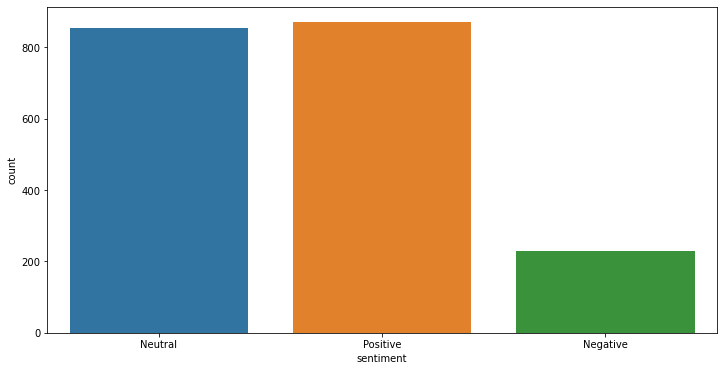

In [37]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df)

C:\Users\BHANUKIRAN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


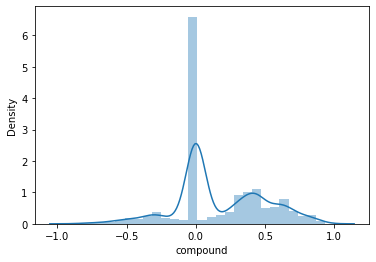

In [38]:
sns.distplot(df['compound'])
plt.show()

<AxesSubplot:ylabel='compound'>

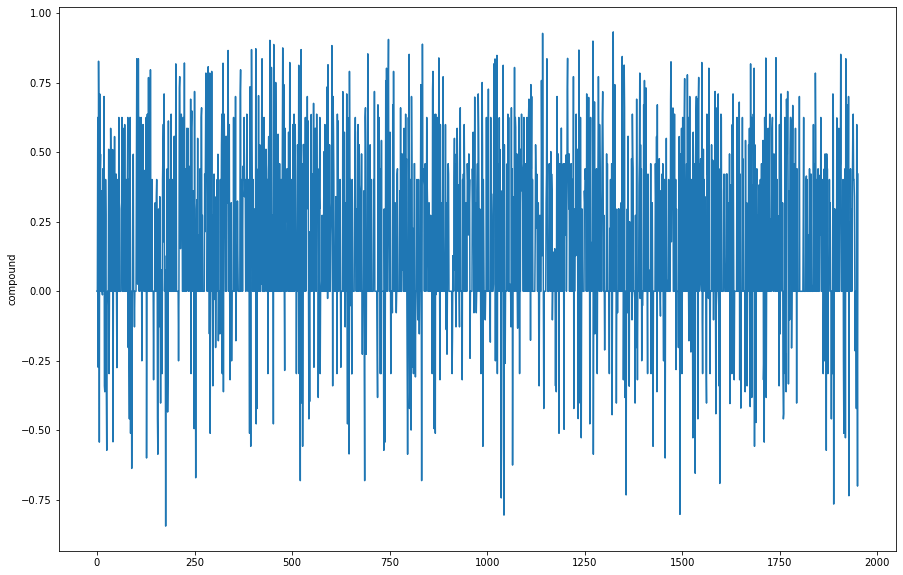

In [39]:
plt.figure(figsize=(15,10))
sns.lineplot(y='compound',x=df.index,data=df)

In [40]:
df['word_count'] = df['Tweets'].apply(lambda x: len(str(x).split(" ")))
df[['Tweets','word_count']].head()

,Tweets,word_count
0,i’m alien,2
1,ray tracing cyberpunk hdr nextlevel,5
2,great interview,2
3,doge underestimated,2
4,congratulation tesla china amazing execution year,6


<AxesSubplot:title={'center':'Sentence sentiment value to sentence word count'}, xlabel='word_count', ylabel='compound'>

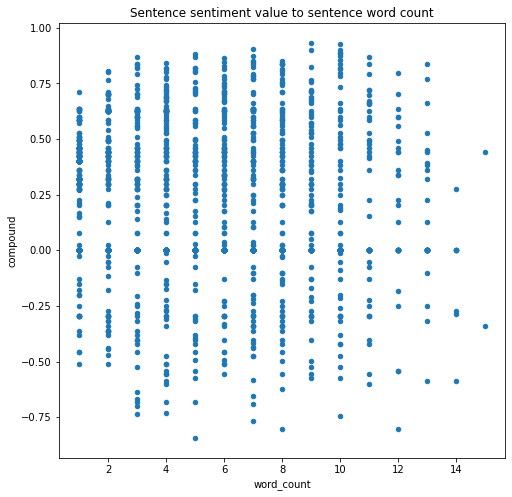

In [41]:
df.plot.scatter(x='word_count',y='compound',figsize=(8,8),
                title='Sentence sentiment value to sentence word count')

### b. Using TextBlob

In [42]:
from textblob import TextBlob
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [43]:
sentiments_using_textblob = tweets.absolute_tidy_tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,absolute_tidy_tweets
pos,1754
neg,197


In [44]:
tweets['sentiment'] = sentiments_using_SIA
tweets.head()

,Tweets,Tidy_Tweets,absolute_tidy_tweets,sentiment
0,@kunalb11 I’m an alien,i’m an alien,i’m alien,pos
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,ray tracing cyberpunk hdr nextlevel,pos
2,@joerogan @Spotify Great interview!,great interview,great interview,pos
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated,neg
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,congratulation tesla china amazing execution year,pos


### Most common words in positive tweets

In [45]:
from wordcloud import WordCloud
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

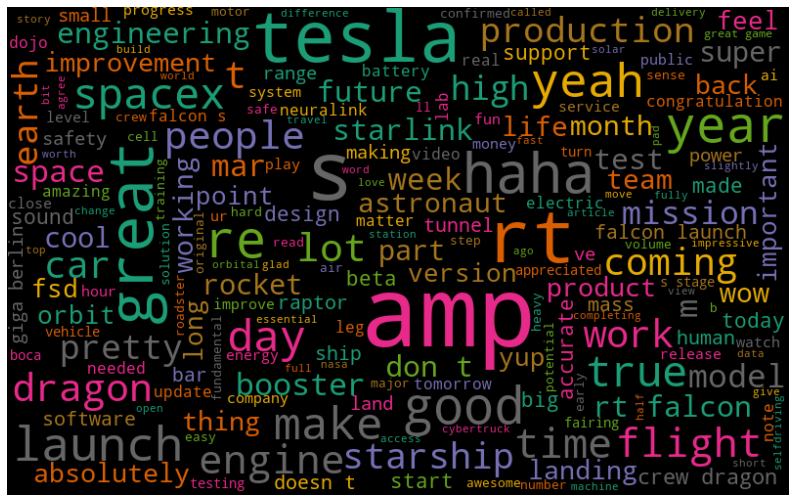

In [46]:
all_words = ' '.join([text for text in tweets['absolute_tidy_tweets'][tweets.sentiment == 'pos']])
generate_wordcloud(all_words)

### Most common words in negative tweets¶

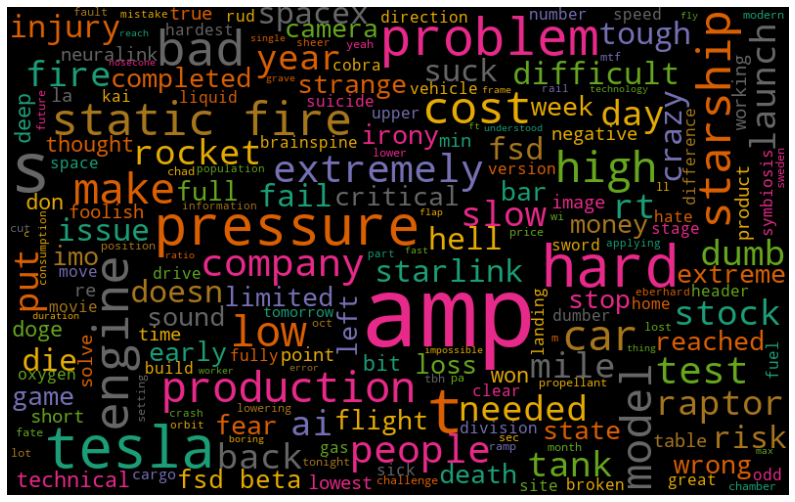

In [47]:
all_words = ' '.join([text for text in tweets['absolute_tidy_tweets'][tweets.sentiment == 'neg']])
generate_wordcloud(all_words)

# Model Building: Sentiment Analysis

In [48]:
target_variable = tweets['sentiment'].apply(lambda x: 0 if x=='neg' else 1)

In [49]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['Positive', 'Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

In [50]:
from sklearn.naive_bayes import GaussianNB
def naive_model(X_train, X_test, y_train, y_test):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train.toarray(), y_train)

    # predictions over test set
    predictions = naive_classifier.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score - {accuracy_score(y_test, predictions)}')
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)

### Feature Extraction for 'Key Words'

In [51]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [52]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
bow_word_feature = bow_word_vectorizer.fit_transform(tweets['absolute_tidy_tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweets['absolute_tidy_tweets'])

#### a. BOW word features

Accuracy Score - 0.5784982935153583


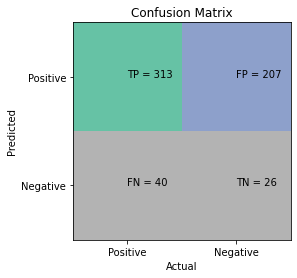

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

#### b. TF-IDF word features

Accuracy Score - 0.5767918088737202


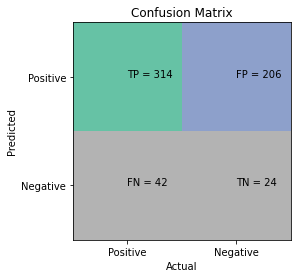

In [54]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)